In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, RocCurveDisplay, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import joblib

from generate_sme import generate_sme

In [2]:
g_sme_obj=generate_sme(1)

In [3]:
data, products_df, df_bin, df_multi=g_sme_obj.final_data()

In [10]:
data

,sme_id,cash_in_30d,cash_out_30d,invoice_vol_30d,od_utilization,relationship_age_days,day,cash_flow_gap,txn_count_30d,avg_txn_value_30d,...,repayment_count_30d,invoice_financed_amt,repayment_amt,od_draw_amt,open_invoice_exposure,od_exposure,total_exposure,utilization_ratio,product_purchased,products
0,SME_0,134884.303900,123251.893685,127508.327055,0.587870,671,1,11632.410215,6.0,22721.526667,...,2.0,0.00,48369.02,55050.22,0.00,6681.20,6681.20,0.049533,none,"[overdraft, invoice_financing, term_loan]"
1,SME_1,44095.887062,38566.366714,42231.461056,0.360266,39,1,5529.520348,7.0,34722.747143,...,0.0,90663.46,0.00,73774.43,90663.46,73774.43,164437.89,2.000000,none,"[overdraft, invoice_financing, term_loan]"
2,SME_2,45977.807981,46179.248850,41144.648119,0.084569,789,1,-201.440869,5.0,25285.650000,...,0.0,25876.74,0.00,20554.76,25876.74,20554.76,46431.50,1.009868,term_loan,"[overdraft, invoice_financing, term_loan]"
3,SME_3,35014.435172,32574.692190,18234.978147,0.058972,731,1,2439.742982,9.0,32544.555556,...,0.0,178579.37,0.00,51753.74,178579.37,51753.74,230333.11,2.000000,overdraft,"[overdraft, invoice_financing, term_loan]"
4,SME_4,92291.176004,88510.257521,93088.753121,0.238110,822,1,3780.918483,2.0,14759.885000,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,none,"[overdraft, invoice_financing, term_loan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,SME_495,39564.439864,39425.881345,18509.885204,0.013632,677,1,138.558519,8.0,33366.067500,...,2.0,81957.12,69787.89,0.00,12169.23,0.00,12169.23,0.307580,invoice_financing,"[overdraft, invoice_financing, term_loan]"
496,SME_496,77998.109858,76880.341620,43832.631222,0.381224,105,1,1117.768239,4.0,21461.037500,...,1.0,25058.64,9654.58,0.00,15404.06,0.00,15404.06,0.197493,overdraft,"[overdraft, invoice_financing, term_loan]"
497,SME_497,19564.201956,20617.641864,21195.668159,0.093400,561,1,-1053.439908,8.0,28853.538750,...,1.0,0.00,50240.24,88481.89,0.00,38241.65,38241.65,1.954675,overdraft,"[overdraft, invoice_financing, term_loan]"
498,SME_498,34411.419444,33949.976762,33198.137949,0.567099,610,1,461.442682,4.0,31965.827500,...,0.0,41444.43,0.00,0.00,41444.43,0.00,41444.43,1.204380,overdraft,"[overdraft, invoice_financing, term_loan]"


In [3]:
import tempfile
private_key_json={'name': 'Usman', 'id': 1}
with tempfile.NamedTemporaryFile(delete=False, suffix=".json") as tmp:
    tmp.write(private_key_json.encode())  # write bytes
    tmp.flush()
    creds_path = tmp.name
creds_path

AttributeError: 'dict' object has no attribute 'encode'

In [4]:
X_bin=df_bin.iloc[:,:-1]
Y_bin=df_bin['is_purchase']

In [5]:
le=LabelEncoder()
y_enc=le.fit_transform(Y_bin)

X_train, X_test, y_train, y_test = train_test_split(X_bin, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
cat=['sme_id', 'product_id']
num=[]
for i in X_bin.columns.to_list():
    if i not in cat:
        num.append(i)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat)
    ],
    remainder='passthrough'
)

pipeline=Pipeline(steps=[('preprocessor', preprocessor)])

X_train_scaled=pipeline.fit_transform(X_train)
X_test_scaled=pipeline.transform(X_test)

In [6]:
lr=LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred=lr.predict(X_test_scaled)
y_prob=lr.predict_proba(X_test_scaled)

report=classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,0,1,accuracy,macro avg,weighted avg
precision,0.892086,0.590909,0.87,0.741498,0.848918
recall,0.964981,0.302326,0.87,0.633653,0.870000
f1-score,0.927103,0.400000,0.87,0.663551,0.851551
support,257.000000,43.000000,0.87,300.000000,300.000000


In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,0])
auc_score = roc_auc_score(y_test, y_prob[:,0])

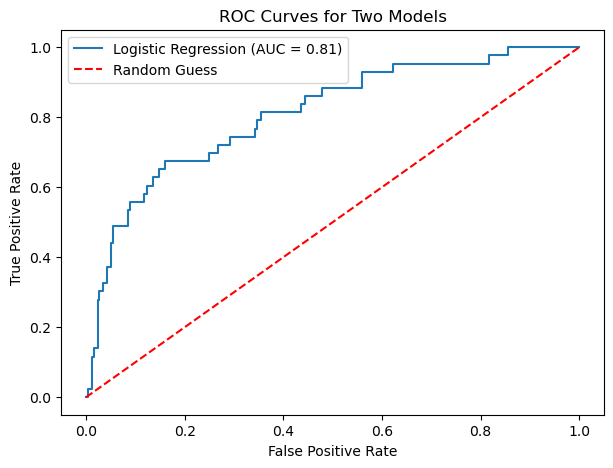

In [8]:
plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{'Logistic Regression'} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [9]:
pipeline=Pipeline(steps=[('preprocessor', preprocessor), ('model', LogisticRegression())])
pipeline.fit(X_bin, y_enc)
joblib.dump(pipeline, 'lr_model.pkl')

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['lr_model.pkl']

In [11]:
xgb = XGBClassifier(
    objective="binary:logistic",
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb.fit(X_train_scaled, y_train)

y_pred = xgb.predict(X_test_scaled)
y_prob = xgb.predict_proba(X_test_scaled)
report=classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report)


,0,1,accuracy,macro avg,weighted avg
precision,0.879562,0.384615,0.836667,0.632089,0.808620
recall,0.937743,0.232558,0.836667,0.585151,0.836667
f1-score,0.907721,0.289855,0.836667,0.598788,0.819160
support,257.000000,43.000000,0.836667,300.000000,300.000000


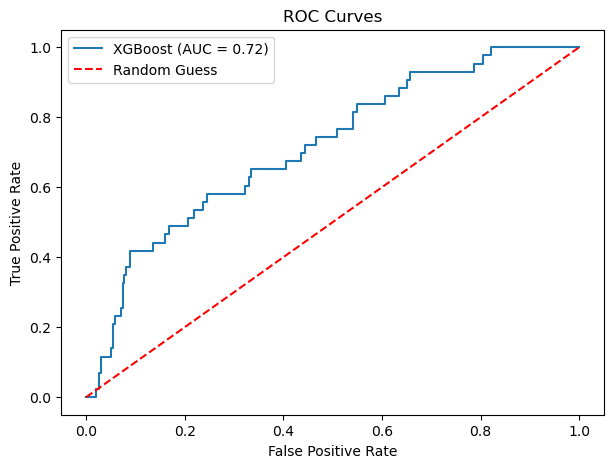

In [12]:
plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{'XGBoost'} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [14]:
pipeline=Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBClassifier(
    objective="binary:logistic",
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
))])
pipeline.fit(X_bin, y_enc)
joblib.dump(pipeline, 'xgb_model.pkl')

['xgb_model.pkl']